# Анализ оттока клиентов банка «Метанпром»
========================================================================================================

# Описание проекта:

Анализ клиентов регионального банка и описание портрета клиентов, которые склонны уходить из банка

**Основной анализ:**

   - Исследовательский анализ данных,
   - Портрет клиентов, склонных уходить из банка,
   - Формулировка и проверка гипотезы различия дохода между теми клиентами, которые ушли и теми, которые остались
   - Вывод и рекомендации

**Дополнительно:**

   - Визуализация исследования путем построения дэшборда:
        1. Диаграмму, отражающую количество клиентов в зависимости от числа используемых продуктов.
        2. Индикатор процента ушедших клиентов.
        3. Фильтр дашборда по городу.


   - По итогам исследования подготовка презентации.

**Описание данных:**

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

**Колонки:**

   - userid — идентификатор пользователя,
   - score — баллы кредитного скоринга,
   - City — город,
   - Gender — пол,
   - Age — возраст,
   - Objects — количество объектов в собственности,
   - Balance — баланс на счёте,
   - Products — количество продуктов, которыми пользуется клиент,
   - CreditCard — есть ли кредитная карта,
   - Loyalty — активный клиент,
   - estimated_salary — заработная плата клиента,
   - Churn — ушёл или нет.


# Оглавление








1. [Загрузка данных](#1)
2. [Предобработка данных](#2)
3. [Исследовательский анализ данных (EDA)](#3)
      * [3.1. Средние значения и стандартные отклонения](#4)
      * [3.2. Анализ тех, кто ушел в отток и тех, кто остался](#5)
          * [3.2.1. Среднее значение в группах](#6)
          * [3.2.2. Столбчатые гистограммы и распределения признаков](#7)
      * [3.3. Матрица корреляций](#8)
4. [Модель прогнозирования оттока клиентов](#9)
      * [4.1. Логистическа регрессия](#10)
      * [4.2. Случайный лес](#11)
      * [4.3. Дерево решений](#12)
      * [4.4. Градиентный бустинг](#13)
      * [4.5. Оценка метрики accuracy, precision, recall, F1 и ROC AUC для всех моделей на валидационной выборке.](#14)
5. [Портрет клиента склонного к оттоку ( Кластеризация)](#15)
6. [Проверка гипотез между теми, кто ушёл и теми, кто остался](#16)
      * [6.1. Статистическая значимость различий в среднем доходе](#17)
      * [6.2. Статистическая значимость различий в возрасте](#18)
      * [6.3. Статистическая значимость различий в размере средств на счете](#19)
7. [Выводы и рекомендации](#22)

In [1]:
#Импорт необходимых библиотек
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from scipy import stats as st
import math
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from pylab import rcParams
import plotly.graph_objects as go

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Загрузка данных
<a id="#1"></a>

In [2]:
#загрузка данных
bank = pd.read_csv('/datasets/bank_dataset.csv')

In [3]:
#пропишем Функцию для обзора датасета, его размера, пропущенные значения, описание, типы даных, и основные статистики
def firstlook(bank):
    print()
    print('==================================')
    print(f'Размер датафрейма \n{bank.shape}')
    print()
    print('===================================================')
    print(f'Info \n{bank.info()}')
    print()
    print('===================================================')
    print(f'Доля пропущенных значений \n{bank.isna().sum()/bank.shape[0]}')
    print()
    print('===================================================')
    print(f'Количество дубликатов \n{bank.duplicated().sum()}')
    print()
    print('===================================================')
    print(f'Описание данных')
    display(bank.describe())
    print('===================================================')
    display(bank.sample(7))
firstlook(bank)
print()
print('===================================================')
print('Количество уникальных значений по столбцам:')
for i in bank.columns:
    print(len(bank[i].unique()), 'в', i)


Размер датафрейма 
(10000, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
userid              10000 non-null int64
score               10000 non-null int64
City                10000 non-null object
Gender              10000 non-null object
Age                 10000 non-null int64
Objects             10000 non-null int64
Balance             6383 non-null float64
Products            10000 non-null int64
CreditCard          10000 non-null int64
Loyalty             10000 non-null int64
estimated_salary    10000 non-null float64
Churn               10000 non-null int64
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB
Info 
None

Доля пропущенных значений 
userid              0.0000
score               0.0000
City                0.0000
Gender              0.0000
Age                 0.0000
Objects             0.0000
Balance             0.3617
Products            0.0000
CreditCard          0.0000
Loyalty         

,userid,score,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.573368e+07,650.528800,38.921800,5.012800,119827.493793,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,30095.056462,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.560844e+07,350.000000,18.000000,0.000000,3768.690000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.567126e+07,584.000000,32.000000,3.000000,100181.975000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.573347e+07,652.000000,37.000000,5.000000,119839.690000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.579597e+07,718.000000,44.000000,7.000000,139512.290000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.585843e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
5839,15815732,594,Ростов Великий,М,40,0,152092.44,2,1,1,83508.93,0
3783,15642596,647,Рыбинск,Ж,26,8,109958.15,1,1,1,136592.24,1
9552,15814745,664,Ярославль,Ж,41,5,NaN,1,1,1,152054.33,0
376,15626192,745,Ростов Великий,М,45,10,117231.63,3,1,1,122381.02,1
54,15612326,601,Ростов Великий,М,42,1,98495.72,1,1,0,40014.76,1
3781,15743778,596,Ростов Великий,Ж,27,2,151027.56,1,1,0,170320.58,0
3419,15726839,674,Ярославль,Ж,26,10,NaN,2,1,1,138423.10,0



Количество уникальных значений по столбцам:
10000 в userid
460 в score
3 в City
2 в Gender
70 в Age
11 в Objects
6382 в Balance
4 в Products
2 в CreditCard
2 в Loyalty
9999 в estimated_salary
2 в Churn


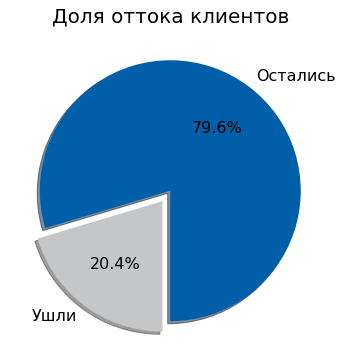

In [4]:
#визуализация доли оттока клиентов
sizes = bank['Churn'].value_counts(sort = True)
colors = ["#005fa8","#c5c6c7"] 
labels = 'Остались', 'Ушли'
explode = (0, 0.1)
rcParams['figure.figsize'] = 6,6

plt.pie(sizes, explode=explode, colors=colors, labels=labels,
        autopct='%1.1f%%', shadow=True, startangle=270, textprops={'fontsize': 16})
plt.title('Доля оттока клиентов', fontdict = {'fontsize' : 20})
plt.show()

✅ **Вывод по разделу:**
- Датафрейм состоит из 10000 строк и 12 столбцов.
- В датафрейме есть пропуски в балансе на счете, но заменять их на 0 не будем - заполнение нулем повлияет на средние значения в группах, игнорируя их мы посчитаем только существующие суммы на счете клиентов.
- Дубликатов нет
- 6 столбцов относятся к нормализованным категорийным переменным. В столбце 'Objects' используются 11 возможных варианта.
- В основном данные полные
- Доля оттока клиентов по выборке составляет 20,4%
- Типизация корректна, кроме гендернего признака.
- Аномалии возможны в данных возраста (92 года клиенту) и заработной плате (11,58), хотя сокрее всего это достоверные значения, так как клиентами банка могут быть люди любого возраста, а заработную плату указывает сам клиент.

**Что нужно сделать:**
- Названия колонок необходимо привести в строчный вид.
- Для правильной работы классификатора необходимо преобразование категориального признака в числовой. Нам нужно изменить
2 столбца: Gender и City. 

<div class='alert alert-success'>
Отличное, бодрое начало. Мне понравилось такое полное и детальное знакомство с данными.

## Предобработка данных
<a id="#2"></a>

In [5]:
#приведем названия столбцов к нижнему регистру:
bank.columns = bank.columns.str.lower()
bank.head(1)

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1


In [6]:
#преобразуем категориальные переменные
encoder =  LabelEncoder()
bank['gender'] =  encoder.fit_transform(bank['gender'])
bank['city'].replace("Ярославль",0, inplace = True)
bank['city'].replace("Рыбинск",1, inplace = True)
bank['city'].replace("Ростов Великий",2, inplace = True)
bank_df = pd.get_dummies(bank, columns=['city'])
bank_df.rename(columns={"city_2": "rost", "city_1": "rub", "city_0": "yars"}, inplace = True)

✅ Предобработка завершена.

## Исследовательский анализ данных (EDA)
<a id="#3"></a>

### Средние значения и стандартные отклонения
<a id="#4"></a>

In [7]:
#для более эстетичной визуализации создадим переименованный список колонок
column_dict = {
    'userid' : 'Идентификатор пользователя',
    'score' : 'Баллы скоринга',
    'city' : 'Город',
    'gender' : 'Пол',
    'age' : 'Возраст',
    'objects' : 'Количество объектов в собственности',
    'balance' : 'Баланс на счёте',
    'products' : 'Количество продуктов у клиента',
    'creditcard' : 'Наличие кредитной карты',
    'loyalty' : 'Активность клиента',
    'estimated_salary' : 'Заработная плата',
    'churn' : 'Отток',
    'yars' : 'Ярославль',
    'rub' : 'Рыбинск',
    'rost' : 'Ростов Великий' 
}

In [8]:
#посмотрим на данные без id
bank_cat_3 = ['age','score', 'objects',
              'balance', 'products', 'estimated_salary',
              'gender', 'creditcard', 'loyalty', 'churn',
              'yars', 'rub', 'rost' ]
bk3 = pd.DataFrame(bank_df, columns=bank_cat_3)

#вывод общей информации по отчету
bank_st = bk3.describe().transpose()[['mean', 'std']]
bank_st.rename(
    columns={"mean": "Среднее значение", "std": "Стандартное отклонение"}, 
    errors="raise",
    inplace=True
)
bank_st.index = bank_st.index.map(column_dict.get)
bank_st

,Среднее значение,Стандартное отклонение
Возраст,38.921800,10.487806
Баллы скоринга,650.528800,96.653299
Количество объектов в собственности,5.012800,2.892174
Баланс на счёте,119827.493793,30095.056462
Количество продуктов у клиента,1.530200,0.581654
Заработная плата,100090.239881,57510.492818
Пол,0.545700,0.497932
Наличие кредитной карты,0.705500,0.455840
Активность клиента,0.515100,0.499797
Отток,0.203700,0.402769


✅ **Вывод**

- Клиенты в выборке равномерно разделены по полу
- Практически половина клиентов имеют кредитные карты данного банка
- Средний возраст клиента - 39 лет
- Значительное стандартное отклонение  в балансе, заработной плате и количестве объектов в собственности, может говорить о большом разбросе доходов клиентов, т.е. клиентами банка могут являться как студенты так и вполне состоятельные граждане.
- Только половина клиентов активно используют продкуты банка

В общем, средний клиент банка имеет 650 балов при скоринге, ему 39 лет, имеет 5 объектов в собственности, на счете у него около 120 тысяч, пользуется 1-2 продуктом банка, имеет кредитную карту, недостаточно активный пользователь и его заработная плата около 100 тысяч.

### Анализ тех, кто ушел в отток и тех, кто остался
<a id="#5"></a>

#### Среднее значение в группах
<a id="#6"></a>

In [9]:
churn_bank = bk3.copy()
churn_bank = churn_bank.groupby('churn').mean().transpose()
churn_bank.rename(
    columns={0: "Остались", 1: "Ушли"}, 
    errors="raise",
    inplace=True
)

churn_bank.index = churn_bank.index.map(column_dict.get)
churn_bank.columns.name = ''
churn_bank\
.style\
.background_gradient(subset=['Остались','Ушли'], cmap='Blues', axis = 1)\
.set_properties(**{'width': '100px'})

,Остались,Ушли
Возраст,37.4084,44.838
Баллы скоринга,651.853,645.351
Количество объектов в собственности,5.03328,4.93274
Баланс на счёте,119536,120747
Количество продуктов у клиента,1.54427,1.47521
Заработная плата,99738.4,101466
Пол,0.572523,0.440844
Наличие кредитной карты,0.707146,0.699067
Активность клиента,0.554565,0.360825
Ярославль,0.527942,0.397644


#### Распределения признаков
<a id="#7"></a>

In [10]:
#распределили признаки на два списка в первом будут количественные данные, а во втором категориальные
spc = ['Возраст','Баллы скоринга', 'Количество объектов в собственности',
            'Баланс на счёте', 'Количество продуктов у клиента', 'Заработная плата']
spc_2 = ['Город','Пол', 'Наличие кредитной карты', 'Активность клиента']

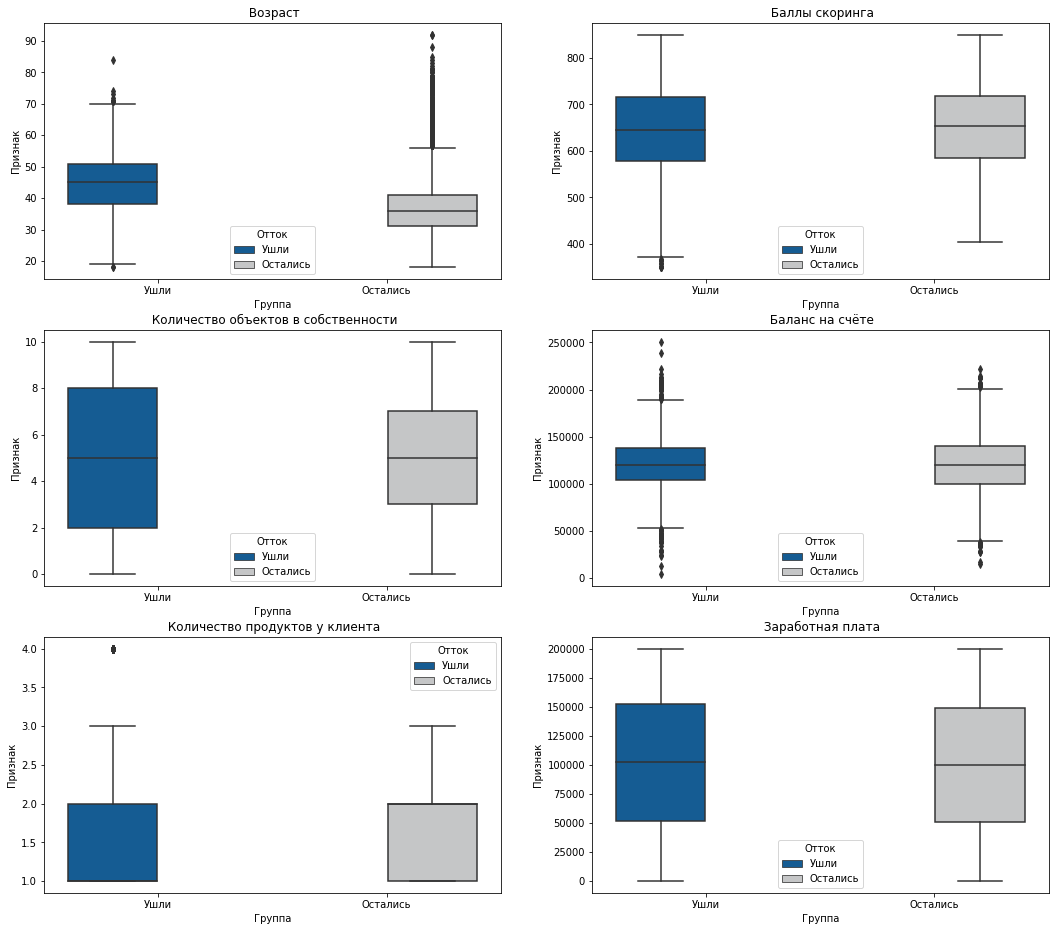

In [11]:
bank_spc = pd.read_csv('/datasets/bank_dataset.csv')
bank_spc.columns = bank_spc.columns.str.lower()
bank_spc.rename(columns=column_dict,inplace=True)
bank_spc['Отток'].replace(0, "Остались", inplace = True)
bank_spc['Отток'].replace(1, "Ушли", inplace = True)
flatui = ["#005fa8","#c5c6c7","#058885", "#cd5b45"]
sns.set_palette(flatui)
a=1
plt.figure(figsize=(18,16))
for i in spc:
    plt.subplot(3,2,a)
    plt.title('' +' '+ i )
    sns.boxplot(data=bank_spc, y=i, x='Отток', hue='Отток')
    plt.xlabel('Группа')
    plt.ylabel('Признак')
    a += 1

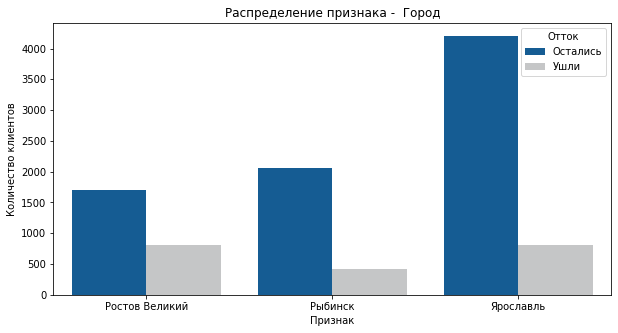

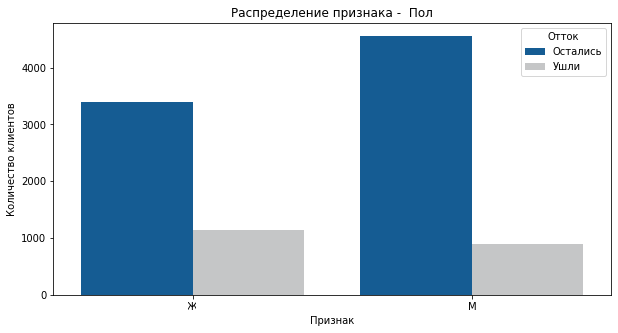

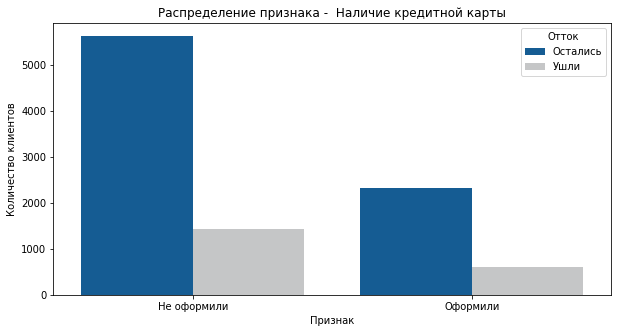

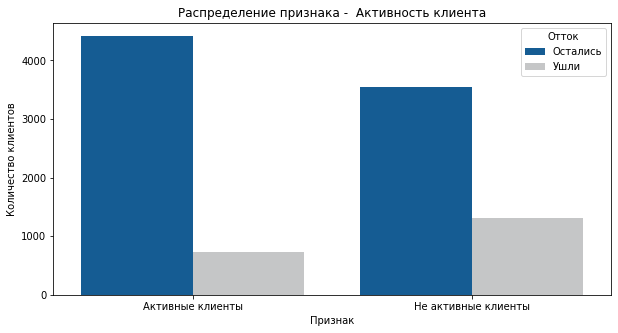

In [12]:
bank_spc['Наличие кредитной карты'].replace(0, "Оформили", inplace = True)
bank_spc['Наличие кредитной карты'].replace(1, "Не оформили", inplace = True)
bank_spc['Активность клиента'].replace(0, "Не активные клиенты", inplace = True)
bank_spc['Активность клиента'].replace(1, "Активные клиенты", inplace = True)
sns.set_palette(flatui)

for i in spc_2:
    tabl = bank_spc.groupby([i,'Отток'])['Идентификатор пользователя'].count().reset_index()
    plt.figure(figsize=(10,5))
    plt.title('Распределение признака - ' +' '+ i )
    sns.barplot(data=tabl, x=i, y='Идентификатор пользователя', hue='Отток')
    plt.ylabel('Количество клиентов')
    plt.xlabel('Признак')

✅ **Вывод**

На удержание лучше сказывается если клиент:
- мужчина
- проживающий в Ярославле
- в молодом возрасте
- имеющий высокий скоринговый балл
- имеющий в наличие большее число объектов в собственности
- открывший несколько продуктов
- с кредитной картой
- активно пользующийся услугами банка

### Матрица корреляций
<a id="#8"></a>

Text(0.5, 1, 'Корреляция Пирсона')

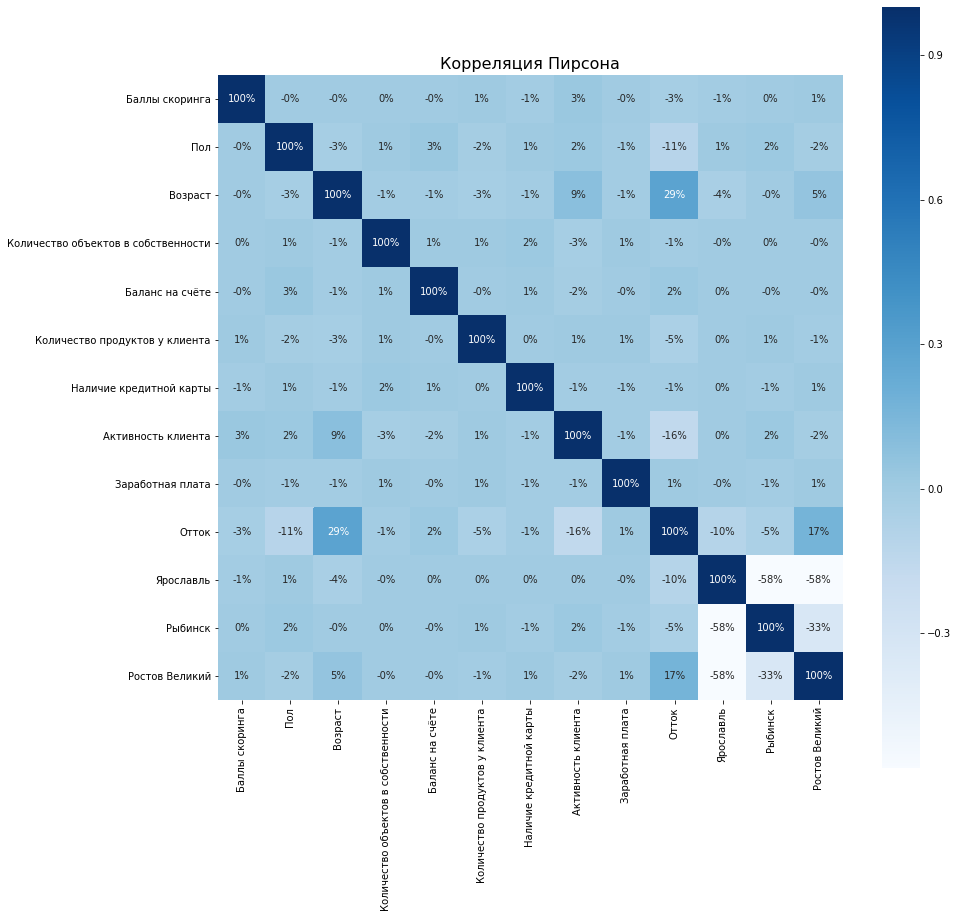

In [13]:
#строим матрицу корреляций
mat_cor = bank_df.copy()
mat_cor.rename(columns=column_dict,inplace=True)
mat_cor = mat_cor.drop(['Идентификатор пользователя'],axis = 1)
bank_cor_mat = mat_cor.corr().round(2)
plt.figure(figsize=(14, 14))
sns.heatmap(
    bank_cor_mat, 
    annot=True, 
    square = True, 
    fmt='.0%',
    cmap="Blues",
    )

plt.title('Корреляция Пирсона', fontsize=16)

✅ **Вывод**

- Корреляционная матрица показывает, какие параметры будут влиять на результат. Сразу можно выделить 4 положительные корреляции: Возраст, местоположение клиента в Ростове Великом, Баланс на счете, Заработная плата. Меньше всего на результат будут влиять: Пол клиента, его Активность, Количество оформленных продуктов и клиенты проживающие в Рыбинске и Ярославле.

В итоговом анализе оставим только признаки имеющие влияние на отток и снова постром матрицу. Также в список добавлю признак наличия кредитной карты, так как сейчас пользование кредитными картами, дающие неплохие кешбеки и скидки на определнные группы товаров в магазинах, является доминирующим продуктом. 

Text(0.5, 1, 'Корреляция Спирмена')

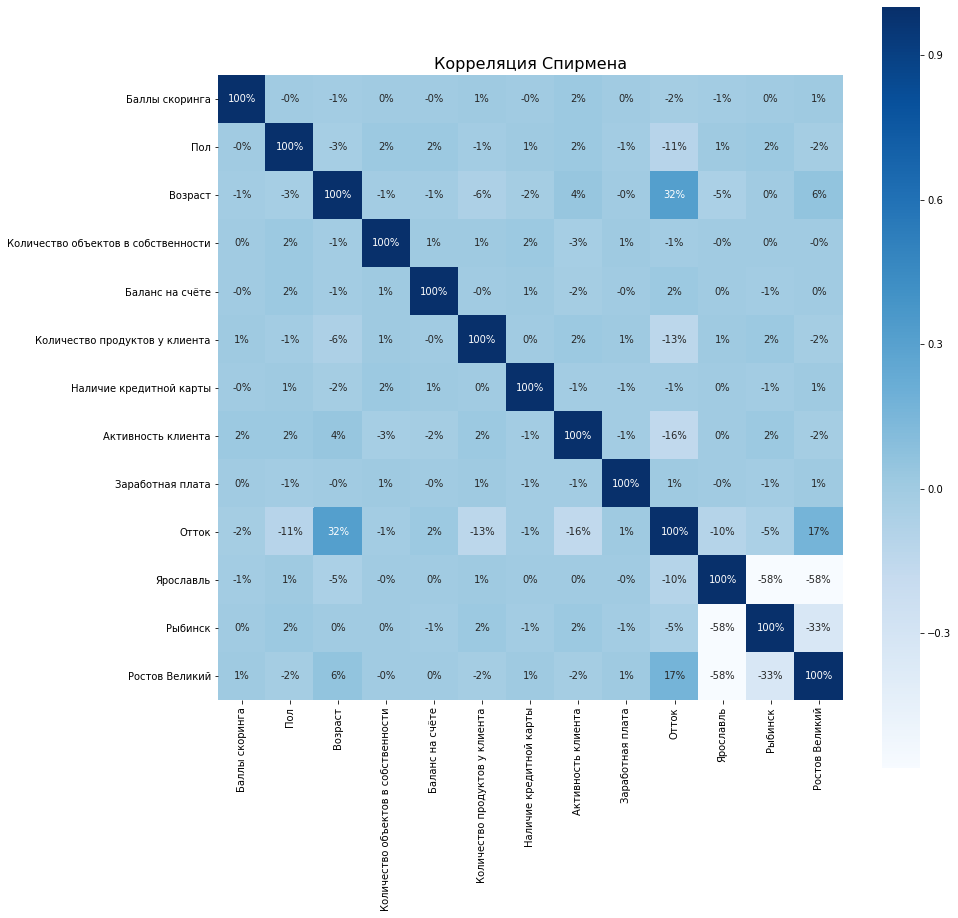

In [14]:
#строим матрицу корреляций Спирмена
mat_cor_sp = bank_df.copy()
mat_cor_sp.rename(columns=column_dict,inplace=True)
mat_cor_sp = mat_cor_sp.drop(['Идентификатор пользователя'],axis = 1)
bank_cor_mat_sp = mat_cor_sp.corr(method='spearman').round(2)
plt.figure(figsize=(14, 14))
sns.heatmap(
    bank_cor_mat_sp, 
    annot=True, 
    square = True, 
    fmt='.0%',
    cmap="Blues",
    )

plt.title('Корреляция Спирмена', fontsize=16)

In [15]:
!pip install phik 
import phik
from phik.report import plot_correlation_matrix
from phik import report

Defaulting to user installation because normal site-packages is not writeable


In [16]:
mat_cor_ph = bank_df.copy()
mat_cor_ph.rename(columns=column_dict,inplace=True)
mat_cor_ph = mat_cor_ph.drop(['Идентификатор пользователя'],axis = 1)
phik_overview = mat_cor_ph.phik_matrix()

interval columns not set, guessing: ['Баллы скоринга', 'Пол', 'Возраст', 'Количество объектов в собственности', 'Баланс на счёте', 'Количество продуктов у клиента', 'Наличие кредитной карты', 'Активность клиента', 'Заработная плата', 'Отток', 'Ярославль', 'Рыбинск', 'Ростов Великий']


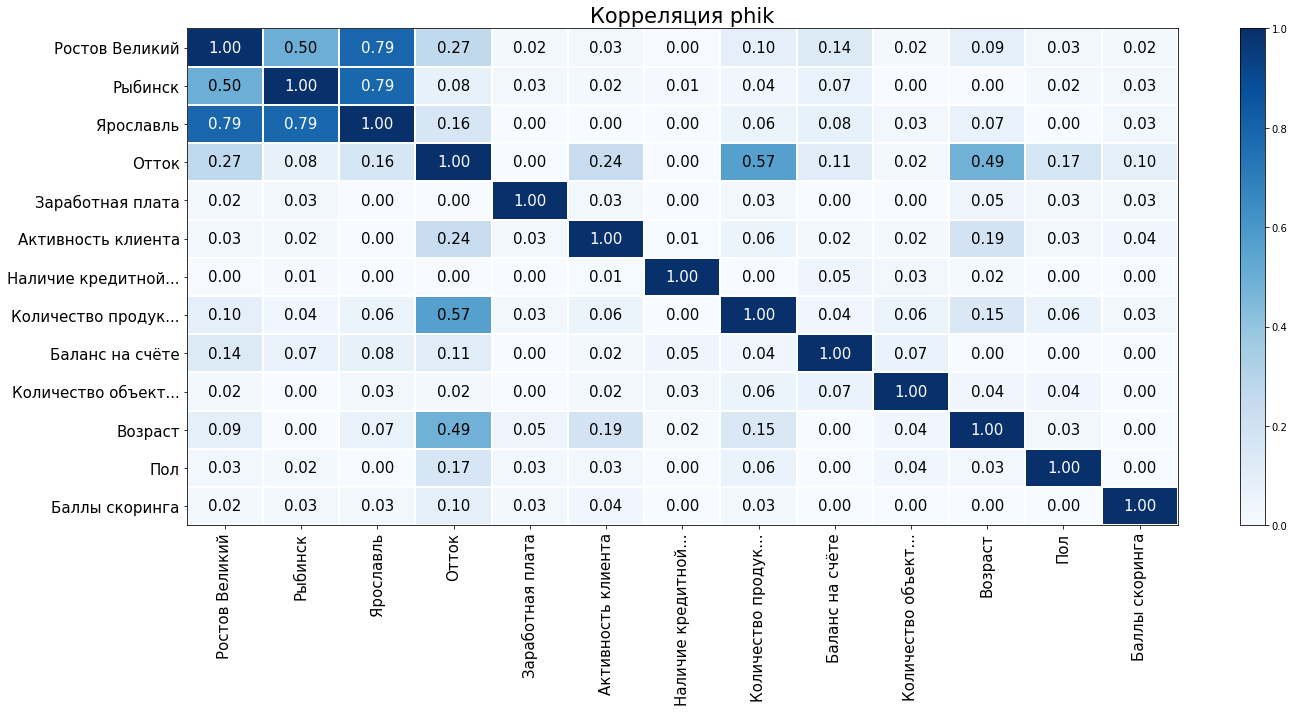

In [17]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title="Корреляция phik", 
                        fontsize_factor=1.5, 
                        figsize=(20, 10))
plt.tight_layout()

In [18]:
#удаляем невлияющие признаки из данных
bank_cor_fin = mat_cor_ph.drop(['Баллы скоринга',
    'Пол','Количество объектов в собственности',
    'Наличие кредитной карты', 'Заработная плата',
    'Ярославль','Рыбинск',],axis = 1)

interval columns not set, guessing: ['Возраст', 'Баланс на счёте', 'Количество продуктов у клиента', 'Активность клиента', 'Отток', 'Ростов Великий']


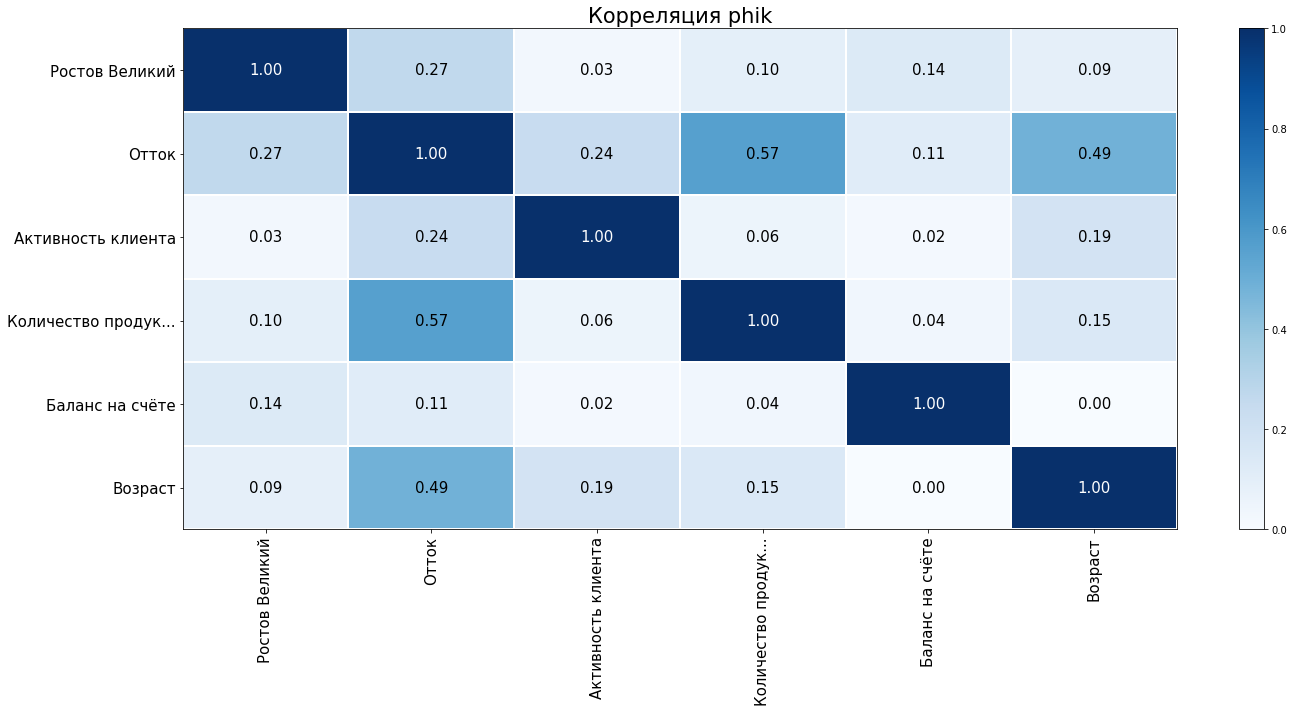

In [19]:
phik_overview = bank_cor_fin.phik_matrix()
phik_overview.round(2)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title="Корреляция phik", 
                        fontsize_factor=1.5, 
                        figsize=(20, 10))
plt.tight_layout()

✅ **Вывод** (Исследовательский анализ данных)

**Анализ первичных данных:**

   - Нашли аномально низкую зарплату в 11 рублей (возможно, клиент не захотел указывать верную ниформацию или не имеет официального дохода)
   - Есть клиенты у которых во владении 10 объектов 
   - в целом везде средние и медианы практически равны, это говорит о незначительном числе выбросов.
   - Значительное стандартное отклонение можем наблюдать только в столбцах данных Возраста, Скоринговых баллов, балансе на счете и заработной плате , что может говорить о большом разбросе доходов и объектов владения наших клиентов.
   - Больше всего клиентов в Ярославле

Группировка по призаку "Ушли / Остались":

   - Среди попавших в отток больше женщин
   - Средний возраст клиентов попавших в отток выше
   - Активный клиент реже попадает в отток
   - Самая высокая доля оттока - из Ростова Великого, почти половина
   - По остальным показателям группы идентичны
   - На матрице корреляций выявили межколлинеарные признаки:
     - Город
     - Баланс на счете
     - Возраст
     - Заработная плата

В целом признаки очень слабо влиют на отток, самое большое влияние оказывает возраст.

## Модель прогнозирования оттока клиентов
<a id="#9"></a>

Построим модель бинарной классификации пользователей, где целевой признак — факт оттока клиентов.

Разделим данные на признаки (матрицу X) и целевую переменную (веткор y) и разобъём данные на обучающую и валидационную выборку функцией train_test_split().

In [20]:
mod_bank = bank_df.copy()
mod_bank.rename(columns=column_dict,inplace=True)
mod_bank['Баланс на счёте'] = mod_bank['Баланс на счёте'].fillna(0)
X = mod_bank.drop('Отток', axis=1)
y = mod_bank['Отток'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [21]:
#стандартизируем данные 
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

In [22]:
#определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, y_proba, title = 'Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

### Логистическая регрессия:
<a id="#10"></a>

In [23]:
#алгоритм для модели
lr_model = LogisticRegression(solver='liblinear')

#обучим модель
lr_model.fit(X_train_st, y_train)

#воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

### Случайный лес:
<a id="#11"></a>

In [24]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)

rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

### Дерево решений
<a id="#13"></a>

In [25]:
tree_model = DecisionTreeClassifier(random_state = 0)

tree_model.fit(X_train_st, y_train)
tree_predictions = tree_model.predict(X_test_st)
tree_probabilities = tree_model.predict_proba(X_test_st)[:,1]

### Градиентный бустинг
<a id="#14"></a>

In [26]:
gb_model = GradientBoostingClassifier(n_estimators = 100, random_state = 0)

gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test_st) 
gb_probabilities = gb_model.predict_proba(X_test_st)[:,1] 

### Оценка метрики accuracy, precision, recall, F1 и ROC AUC для всех моделей на валидационной выборке. 
<a id="#15"></a>

In [27]:
print_all_metrics(y_test, lr_predictions, lr_probabilities , title='Метрики для модели логистической регрессии:')
print()
print_all_metrics(y_test, rf_predictions, rf_probabilities, title = 'Метрики для модели случайного леса:')
print()
print_all_metrics(y_test, tree_predictions, tree_probabilities, title='Метрики для модели дерева решений:')
print()
print_all_metrics(y_test, gb_predictions, gb_probabilities, title = 'Метрики для модели градиентного бустинга:')

Метрики для модели логистической регрессии:
	Accuracy: 0.81
	Precision: 0.58
	Recall: 0.22
	F1: 0.31
	ROC_AUC: 0.77

Метрики для модели случайного леса:
	Accuracy: 0.86
	Precision: 0.79
	Recall: 0.43
	F1: 0.56
	ROC_AUC: 0.85

Метрики для модели дерева решений:
	Accuracy: 0.79
	Precision: 0.48
	Recall: 0.48
	F1: 0.48
	ROC_AUC: 0.67

Метрики для модели градиентного бустинга:
	Accuracy: 0.20
	Precision: 0.20
	Recall: 1.00
	F1: 0.34
	ROC_AUC: 0.32


In [28]:
#посмотрим на важность признаков. 
importances = pd.DataFrame({'Признак': X.columns, 'Значимость':rf_model.feature_importances_})
importances.sort_values(by='Значимость', ascending=False)

,Признак,Значимость
3,Возраст,0.230636
6,Количество продуктов у клиента,0.123337
5,Баланс на счёте,0.118267
9,Заработная плата,0.117896
0,Идентификатор пользователя,0.115885
1,Баллы скоринга,0.114626
4,Количество объектов в собственности,0.069584
8,Активность клиента,0.035372
12,Ростов Великий,0.022421
2,Пол,0.017643


✅ **Вывод**

- Из четырех представленных алгоритмов наилучший результат показал Случайный лес. Точность предсказания составляет 85%. 

Самый важный признак для модели - Возраст. Модель можно использовать, чтобы предотвратить отток тех, кому она предсказывает уход, но клиент еще не успел. Или для сравнения прогнозного значения продуктов и фактического. Тем, у кого прогнозное больше, можно предложить новый продукт.

## Портрет клиента склонного к оттоку ( Кластеризация)
<a id="#16"></a>

In [29]:
bank_cl = bank_df.copy()
bank_cl = bank_cl.drop('churn', axis=1)
bank_cl.rename(columns=column_dict,inplace=True)
#заменяем пропуски на 0, так как денрограмма их не принимает 
bank_cl['Баланс на счёте'] = bank_cl['Баланс на счёте'].fillna(0)

#стандартизация данных
x_cl= scaler.fit_transform(bank_cl)

#построение матрицы расстояний 
linked = linkage(x_cl, method = 'ward')

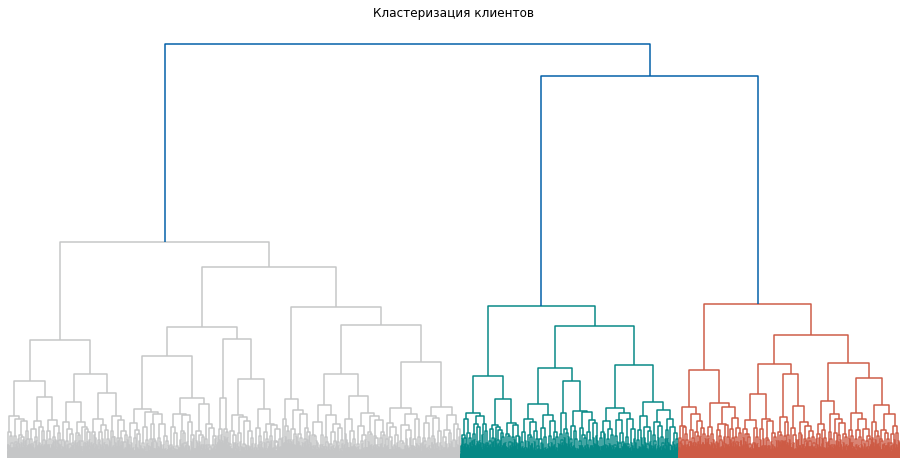

In [30]:
# построение дендрограммы
plt.figure(figsize=(16, 8))  
dendrogram(linked, orientation='top', no_labels=True)
sns.despine(
    left=True, 
    bottom=True
)
plt.gca().set_yticks([])
plt.title('Кластеризация клиентов')
plt.show()

In [31]:
#задаём модель k_means с числом кластеров 3
km = KMeans(n_clusters=3, random_state=0)
#прогнозируем кластеры для наблюдений
labels = km.fit_predict(x_cl)

In [32]:
#посмотрим на средние значения
bank_cl['Кластер']  = labels
cluster = bank_cl.drop(['Идентификатор пользователя'], axis=1).groupby('Кластер').mean().T
cluster.columns = cluster.columns.astype('str')

#форматирование таблицы
format_dict = {'0': '{:.2f}','1': '{:.2f}','2': '{:.2f}'}
cluster\
.style\
.format(format_dict)\
.background_gradient(subset=['0','1','2'], cmap='Blues', axis = 1)\
.set_properties(**{'width': '100px'})

Кластер,0,1,2
Баллы скоринга,651.45,649.67,651.33
Пол,0.52,0.55,0.56
Возраст,39.77,38.51,38.89
Количество объектов в собственности,5.01,5.00,5.03
Баланс на счёте,119730.12,62092.64,61818.15
Количество продуктов у клиента,1.52,1.53,1.54
Наличие кредитной карты,0.71,0.71,0.69
Активность клиента,0.50,0.52,0.53
Заработная плата,101113.44,99899.18,99440.57
Ярославль,0.00,1.00,0.00




**Построим распределения признаков для кластеров**



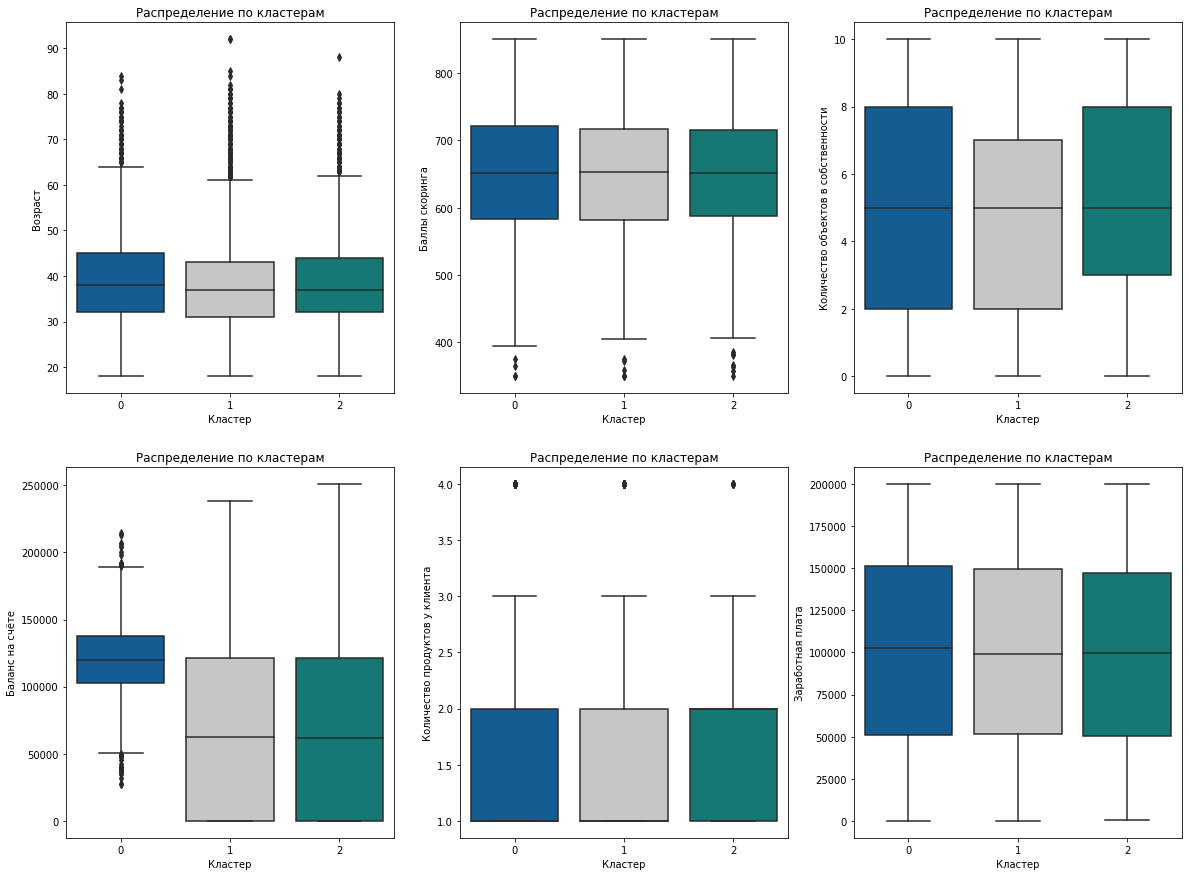

In [33]:
plt.figure(figsize=(20,15))
sns.set_palette(flatui)
for i, col in enumerate(spc):
    sns.boxplot(x='Кластер', y=col, data=bank_cl, ax=plt.subplot(2,3,i+1))
    plt.title("Распределение по кластерам")

In [34]:
bank_cls_cat = pd.read_csv('/datasets/bank_dataset.csv')
bank_cls_cat.columns = bank_cls_cat.columns.str.lower()
bank_cls_cat.rename(columns=column_dict,inplace=True)
bank_cls_cat['Кластер']  = labels
bank_cls_cat=bank_cls_cat[['Идентификатор пользователя','Город', 'Пол', 'Наличие кредитной карты', 'Активность клиента', 'Отток', 'Кластер' ]]
bank_cls_cat.sample(3)


,Идентификатор пользователя,Город,Пол,Наличие кредитной карты,Активность клиента,Отток,Кластер
8325,15725225,Ярославль,М,1,0,0,1
9785,15651923,Ярославль,Ж,0,0,0,1
266,15696593,Ярославль,М,1,1,0,1


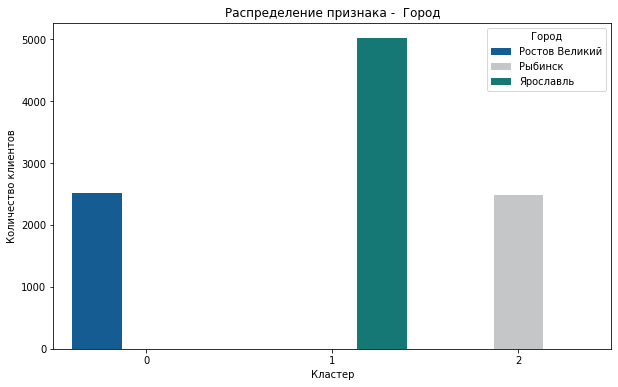

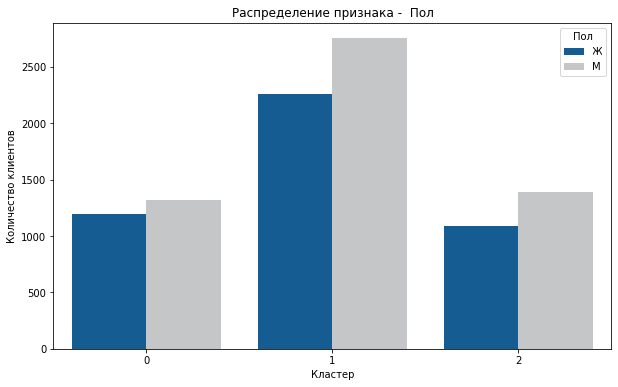

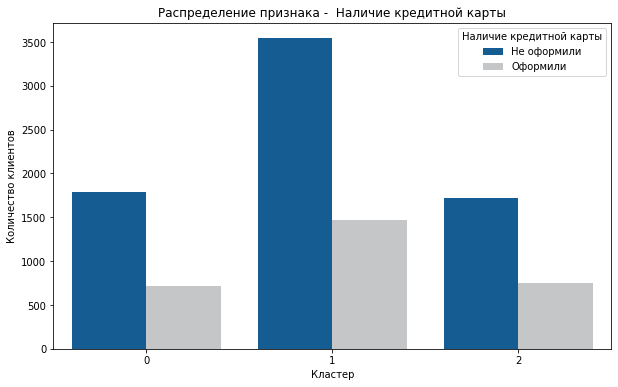

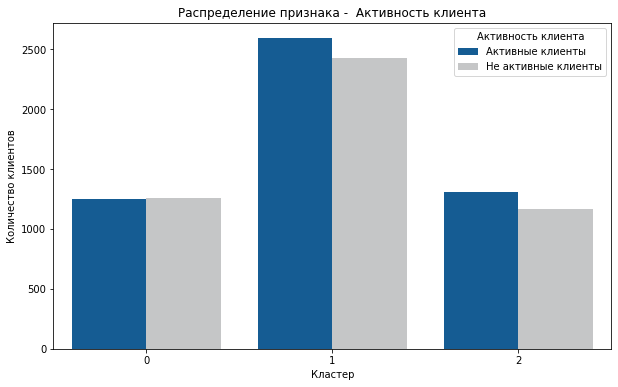

In [35]:
bank_cls_cat['Наличие кредитной карты'].replace(0, "Оформили", inplace = True)
bank_cls_cat['Наличие кредитной карты'].replace(1, "Не оформили", inplace = True)
bank_cls_cat['Активность клиента'].replace(0, "Не активные клиенты", inplace = True)
bank_cls_cat['Активность клиента'].replace(1, "Активные клиенты", inplace = True)
sns.set_palette(flatui)
for i in spc_2:
    tabl = bank_cls_cat.groupby([i,'Кластер'])['Идентификатор пользователя'].count().reset_index()
    plt.figure(figsize=(10,6))
    plt.title('Распределение признака - ' +' '+ i )
    sns.barplot(data=tabl, x='Кластер', y='Идентификатор пользователя', hue=i)
    plt.ylabel('Количество клиентов')
    plt.xlabel('Кластер')

In [36]:
# доля оттока по каждому кластеру
round(bank_cls_cat.query('Отток==1').groupby('Кластер')['Отток']\
      .count() / bank_cls_cat.groupby('Кластер')['Отток'].count(),2).map('{:,.0%}'.format)

Кластер
0    32%
1    16%
2    17%
Name: Отток, dtype: object

✅ **Вывод**

**Портрет клиента склонного к уходу:**

Средний клиент, который вероятно покинет банк проживает в Ростове Великом, имеет средний возраст 39 лет, среднюю зарплату около 100 тысяч, держит на балансе в районе 60 тысяч и пользуется кредитной картой.


## Проверка гипотез между теми, кто ушёл и теми, кто остался
<a id="#17"></a>

На основании проведенного анализа, появились предположения, что на отток клиентов влияют следующие признаки: возраст, баланс на счете, размер заработной платы, наличие кредитной карты, местонахождение. Сформулируем и проверим статистические гипотезы.

In [37]:
#критический уровень статистической значимости
alpha = 0.05

### Статистическая значимость различий в среднем доходе 
<a id="#18"></a>

In [38]:
#посмотрим на разницу в среднем доходе между группами
salary = bank_df.groupby('churn')['estimated_salary'].mean().reset_index().T.round().drop('churn', axis = 0)
salary

,0,1
estimated_salary,99738.0,101466.0


У клиентов из оттока средний доход выше на 2 тыс. руб. Посмотрим, статистически значима ли разница. Для этого сформулируем гипотезы и проведем A/B тест

Гипотезы

   - H0: Между группами churn и no_churn нет различий в доходе
   - H1: Между группами churn и no_churn есть различие в доходе

In [39]:
salary_1 = bank_df.query('churn == 0')['estimated_salary']
salary_2 = bank_df.query('churn == 1')['estimated_salary']
results = st.mannwhitneyu(salary_1, salary_2, True, 'less')

print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.11352575465076892
Не получилось отвергнуть нулевую гипотезу


### Статистическая значимость различий в возрасте 
<a id="#19"></a>

In [40]:
age = bank_df.groupby('churn')['age'].mean().reset_index().T.round().drop('churn', axis = 0)
age

,0,1
age,37.0,45.0


У клиентов из оттока средний возраст выше на 8 лет. Посмотрим, статистически значима ли разница. Для этого сформулируем гипотезы и проведем A/B тест

Гипотезы

   - H0: Между группами churn и no_churn нет различий в возрасте
   - H1: Между группами churn и no_churn есть различие в возрасте

In [41]:
age_1 = bank_df.query('churn == 0')['age']
age_2 = bank_df.query('churn == 1')['age']
results = st.mannwhitneyu(age_1, age_2, True, 'less')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.6052007159685838e-230
Отвергаем нулевую гипотезу


### Статистическая значимость различий в размере средств на счете
<a id="#20"></a>

In [42]:
balance = bank_df.copy()
balance['balance'] = balance['balance'].fillna(0)
balance_mean = balance.groupby('churn')['balance'].mean().reset_index().T.round(2).drop('churn', axis = 0)
balance_mean

,0,1
balance,72745.3,91108.54


У клиентов из оттока денег на счету больше на 20 тысяч. Посмотрим, статистически значима ли разница. Для этого сформулируем гипотезы и проведем A/B тест

Гипотезы

   - H0: Между группами churn и no_churn нет различий в размере средств
   - H1: Между группами churn и no_churn есть различие в размере средств

In [43]:
balance_1 = balance.query('churn == 0')['balance']
balance_2 = balance.query('churn == 1')['balance']
results = st.mannwhitneyu(balance_1, balance_2, True, 'less')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 5.579199689574611e-29
Отвергаем нулевую гипотезу


✅ **Вывод:**

**После проверки гипотез можем сделать следующие выводы:**
1. На отток клиентов из банка в основном влияет Возраст клиента - чем выше возраст, тем вероятнее что клиент покинет банк).
2. Не подтвердились гипотезы о том, что на отток влияют доход клиента и размер средств на счете. 

## Выводы и рекомендации
<a id="#23"></a>

✅ **Общий вывод:**

   - В выборку анализа попали 10 тысяч клиентов банка из городов Ярославль, Рыбинск, Ростов Великий, в возрасте от 18 до 92 лет. Отчет содержит также данные клиентов об их скоринговом балле, количестве объектов в собственности, размере средств на счете и заработной плате, наличии оформленной кредитной карты.
   - Доля оттока клиентов по выборке составляет 20,4%
   - Клиенты в выборке равномерно разделены по гендерному признаку
   - Практически половина клиентов имеют кредитные карты данного банка
   - Средний возраст клиента - 39 лет
   - Значительное стандартное отклонение наблюдается в балансе, заработной плате и количестве объектов в собственности.
   - Только половина клиентов активно используют продкуты банка
   
   
**По результатам исследовательского анализа на удержание лучше сказывается если клиент:**
   - мужчина
   - проживающий в Ярославле
   - в молодом возрасте
   - имеющий высокий скоринговый балл
   - имеющий в наличие большее число объектов в собственности
   - открывший несколько продуктов
   - с кредитной картой
   - активно пользующийся услугами банка
   
   - построенная матрица корреляции показала, что в целом признаки очень слабо влиют на отток, а самое большое влияние оказывает возраст. Меньше всего на результат отттока будут влиять: Пол клиента, его Активность, Количество оформленных продуктов и клиенты проживающие в Рыбинске и Ярославле.
   
**Построенная модель прогнозирования оттока клиентов показала:**
   - Из четырех представленных алгоритмов наилучший результат показал Случайный лес. Точность предсказания составляет 85%. Самый важный признак оттока рассчитанный моделью - Возраст.
   
**Таким образом, портрет клиента склонного к уходу из банка может иметь следующий образ:**   
  - в преобладающих случаях это женщина, в возрасте около 39 лет, проживающая в Ростове Великом, получает среднюю зарплату около 100 тысяч, держит на балансе в районе 60 тысяч и пользуется кредитной картой.

**После проверки гипотез можно сделать следующие выводы:**
  - На отток клиентов из банка в основном влияет Возраст клиента - чем выше возраст, тем вероятнее что клиент покинет банк).
  - Не подтвердились гипотезы о том, что на отток влияют доход клиента и размер средств на счете.
   
✅ **Рекомендации:**

- Необходимо удержать более возрастную категорию клиентов, направив разработку продукта именно на эту группу клиентов.
- Разобраться с ситуацией в Ростове Великом - почему наибольший отток клиентов идет из этого города.
- Увеличивать лояльность - привлекать клиентов к более активному использованию приложения/продуктов банка.
- Предложить оформить дополнительные услуги банка клиентам с одним продуктом